# Mount Google drive and import files

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!cp drive/My*/ALE_Python/*.py /content/
#!rm -r -f training_*/*

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Train Auto-encoder

Snapshot generator Burgers equation
0.010101010101010102
0.002506265664160401
simulation time: 0.15206098556518555
ttt 0.9999999999999889


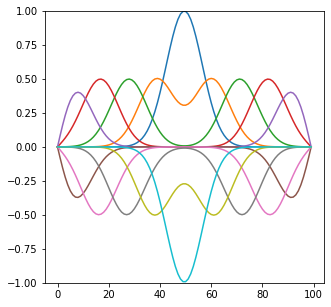

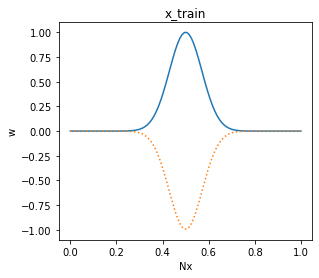

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os as os
import datetime
import numpy as np
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import pickle
import time as time
from scipy.optimize import minimize
from numpy.linalg import norm

equation = 'waves'; # burgers, Lconv, wave

if equation == 'burgers':
    from snapshot_gen_burgers import snapshot_gen_burgers as snapshot_gen
    ymin, ymax = 0.7, 1.3
    wave_speed = 0;
    bc = 0.8
    batch_repeat = 1
    x_mid_0 = 0.25;
elif equation == 'Lconv':
    from snapshot_gen import snapshot_gen_v1 as snapshot_gen
    ymin, ymax = -0.1, 1.1
    wave_speed = 0.5;
    bc = 0
    batch_repeat = 2.
    x_mid_0 = 0.5;
elif equation == 'waves':
    from snapshot_gen_wave import snapshot_gen_wave as snapshot_gen
    ymin, ymax = -1.1, 1.1
    wave_speed = 0;
    bc = 0
    batch_repeat = 2
    x_mid_0 = 0.5;
    xmax = 1;#2.5;
    tmax = 1;
    Nx = 100;
    Ny = 100
    Nt = 400;
    #  ALE optimization parameters
    k_x = 1*2;
    k_w = 2;
    # ALE optimization hyper-parameters
    Gamma_0_x = 1e1;
    Gamma_0_t = 1e1;
    size_x = 15;
    size_t = 15;#15;

maxiter = 1;

from snapshot_gen_burgers import fd_normal

from snapshot_gen_burgers import snapshot_decode

#from objective_ALE import callbackF

from objective_ALE import objective_ALE_clean as objective_fun
from objective_ALE import constraint_fun

from objective_ALE import gridgen_coarse_UV_fine
from objective_ALE import SVD_project
from objective_ALE import grid_spacing
from objective_ALE import interp1d_loop

from objective_ALE import UV_init_boundary
from objective_ALE import UV_init
from objective_ALE import UV_boundary

boundary_function_map = {
    # Make initial condition uniform
#    'UV_init': UV_init,
    # Free initial condition
    'UV_init': lambda V: V,
    # Make boundary fixed
    'UV_boundary': UV_boundary
    # Free boundary
#    'UV_boundary': lambda U: U
}

#from scipy.interpolate import interp1d as interp1
#from myplot import myplot
#%%
x_0 = np.linspace(0,xmax,Nx);
M_x_0 = np.repeat(x_0,Nt,axis=0).reshape(Nx,Nt);

t_0 = np.linspace(0,tmax,Nt);
M_t_0 = np.repeat(t_0,Nx,axis=0).reshape(Nt,Nx).T;

dxmin = 1/Nx/10;
#%% Snapshot generation
(x_train_org, y_train_org, x, t) = snapshot_gen(xmax, tmax, x_mid_0, Nx, Nt, wave_speed, batch_repeat)
X_E_FOM = y_train_org[0,:,:].reshape(Nx,Nt);

fig = plt.figure(figsize=(10, 4))

ax1 = plt.subplot(121)
plt.plot(x, X_E_FOM[:,0] )
plt.plot(x, X_E_FOM[:,-1], linestyle='dotted' )
plt.xlabel('Nx')
plt.ylabel('w')
plt.title('x_train')
plt.ylim(ymin, ymax )

plt.show()
#%% ALE optimization parameters and hyper-parameters to dictionary 
k = {
  "x": k_x,
  "w": k_w
      }

Gamma_0 = {
        "x": Gamma_0_x, 
        "t": Gamma_0_t
           }
#%% Inital condition for basis functions
ix_fine = np.linspace(0,Nx-1,Nx);
it_fine = np.linspace(0,Nt-1,Nt);

it = list(np.floor(np.linspace(0,Nt-1,size_t)));
ix = list(np.floor(np.linspace(0,Nx-1,size_x)));

d0 = 0;
U_x = d0*np.ones((Nx ,k['x']))/np.sqrt(k['x']);
V_x = np.linspace(0,tmax,Nt) *  np.ones((k['x'],Nt))/np.sqrt(k['x']);
[U_x , V_x] = UV_init_boundary(U_x , V_x, boundary_function_map);


U_x = np.take(U_x,ix,axis=0); # U_x = U_x(ix,: );
V_x = np.take(V_x,it,axis=1); # V_x = V_x(: ,it);
#
q =  np.concatenate((U_x.reshape(size_x*k['x']),  V_x.reshape(k['x'] * size_t ) )); #q = U_x.reshape(size_x*k['x'])  V_x.reshape(k['x'] * size_t )   #[U_d(:);V_d(:)];
Flag = [U_x.size, V_x.size]; #Flag = [length(U_d(:)), length(V_d(:))];
#
#%% Regularization terms (Smoothness)
Gamma_x = fd_normal(Nx,3,ix_fine,2);
Gamma_t = fd_normal(Nt,3,it_fine,2);

## Run the optimization

In [3]:
global ps
ps = [q]
def callbackF(Xi):
    global ps
    ps.append(Xi)
    print('Norm of current time step:', str(norm(Xi)) )
ineq_cons = {'fun' : 
    lambda q:   (constraint_fun(q, 
                               k_x, Flag, Nx, Nt,
                               size_x, ix, ix_fine, 
                               size_t, it, it_fine,
                               M_x_0,
                               boundary_function_map)-dxmin).reshape((Nx-1)*Nt),
             'type': 'ineq'
             }
t = time.time()
qq = minimize(
        lambda q: norm(objective_fun(q,
                                 x_0, M_x_0, Nx, M_t_0, Nt, bc, 
                                 k, X_E_FOM,  Gamma_x , Gamma_t, Gamma_0,
                                 Flag, 
                                 size_x, ix, ix_fine, 
                                 size_t, it, it_fine,
                                 boundary_function_map)),
                                 q,
                                 method='SLSQP',# 'COBYLA', 'SLSQP'
                                 constraints= ineq_cons,
                                 options={'maxiter': maxiter, 'disp': True},
                                 callback=callbackF)
t = time.time() - t
qq['hisq']=ps # Add histiry of qq.x to 
print('ALE optimization time:',t, 's, = ',t/60.0,'min')

Norm of current time step: 2.2925490782691953
Norm of current time step: 2.273748945195454
Iteration limit exceeded    (Exit mode 9)
            Current function value: 22.297423625098595
            Iterations: 2
            Function evaluations: 126
            Gradient evaluations: 2
ALE optimization time: 10.546867847442627 s, =  0.17578113079071045 min


In [0]:
#%% Save ALE optimization
# file_name_opt = 'ALE_'+equation+'_kx='+str(k_x)+'_kw='+str(k_w)+'.pkl'
# f = open(file_name_opt,"wb")
# pickle.dump(qq,f)
# f.close()

# os.system('cp '+'/content/'+file_name_opt+' '+'drive/My*/ALE_Python/')

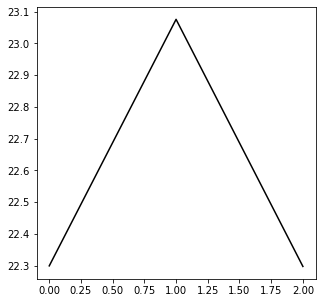

In [5]:
%matplotlib inline

#%% Optimization History 
ps = qq['hisq']
ps = np.array(ps)
norm_hist_list = []
for iter in range(0,ps.shape[0]):
    norm_hist = norm(objective_fun(ps[iter],
                                x_0, M_x_0, Nx, M_t_0, Nt, bc, 
                                k, X_E_FOM,  Gamma_x , Gamma_t, Gamma_0,
                                Flag, 
                                size_x, ix, ix_fine, 
                                size_t, it, it_fine,
                                boundary_function_map))
    norm_hist_list.append(norm_hist)

fig_ALE = plt.figure(figsize=(5, 5));
plt.plot(norm_hist_list,'k-')

In [0]:
[M_x_ALE, dx, U_xx, V_xx] = gridgen_coarse_UV_fine(qq.x*0, 
                           k_x, Flag, Nx, Nt,
                           size_x, ix, ix_fine, 
                           size_t, it, it_fine,
                           M_x_0,
                           boundary_function_map,
                           mykind='linear');
#
M_w_ALE = interp1d_loop(M_x_0, X_E_FOM, M_x_ALE, Nx, Nt, bc, mykind='linear');
#
M_w_Proj, U, V = SVD_project(M_w_ALE, k_w, output_UV = True);
#
X_ROM_Proj = interp1d_loop(M_x_ALE, M_w_Proj, M_x_0, Nx, Nt, bc);

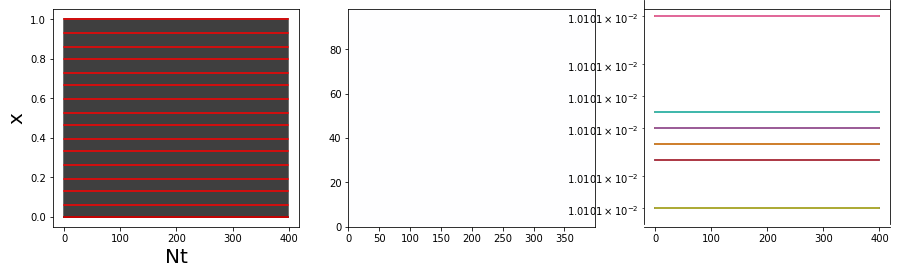

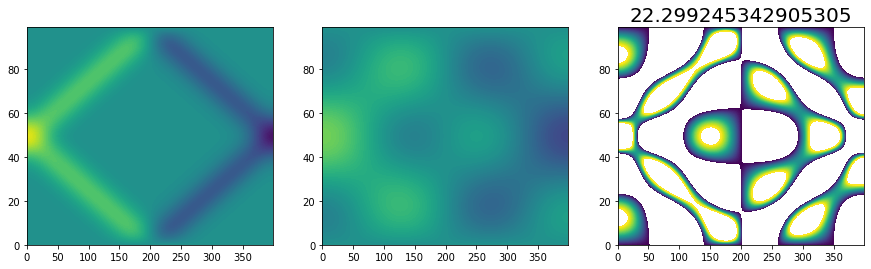

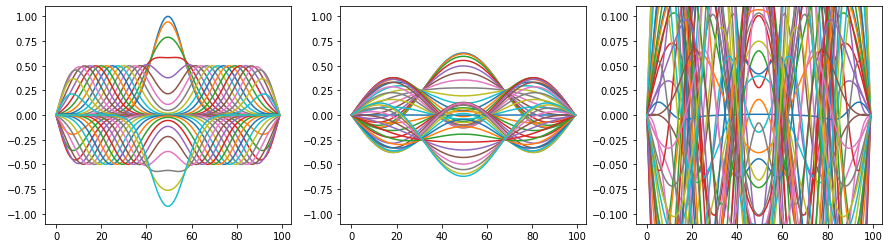

In [7]:
#%%
%matplotlib inline
import matplotlib.pyplot as plt

from matplotlib import ticker, cm

fig_ALE = plt.figure(figsize=(15, 4));
# Plot ALE Grid
ax1 = plt.subplot(131)
plt.plot(np.transpose(M_x_ALE[np.linspace(1,Nx,101).astype(int)-1,:]),'k-')
plt.plot(np.transpose(M_x_ALE[np.linspace(1,Nx,16).astype(int)-1,:]),'-r')
plt.xlabel('Nt',  fontsize=20)
plt.ylabel('x' ,  fontsize=20)
# ALE Grid Spacing - Contour
ax1 = plt.subplot(132)
cf = plt.contourf( grid_spacing(M_x_ALE).T , locator=ticker.LogLocator(), cmap=cm.bwr_r ); 
fig.colorbar(cf)
# ALE Grid Spacing - Line plots
ax1 = plt.subplot(133)
plt.semilogy( grid_spacing(M_x_ALE) );
 
plt.show();
fig_ALE.savefig('fig_ALE', format="svg")
#%%
fig = plt.figure(figsize=(15, 4));
ax1 = plt.subplot(131)
plt.contourf(X_E_FOM, np.linspace(ymin, ymax, 100))

ax1 = plt.subplot(132)
plt.contourf(X_ROM_Proj,  np.linspace(ymin, ymax, 100))

ax1 = plt.subplot(133)
plt.contourf(X_E_FOM-X_ROM_Proj,  np.linspace(0, 0.1*ymax, 100))
plt.title(str(norm(X_E_FOM-X_ROM_Proj)),  fontsize=20)

plt.show()
#%%
dNt = 10;

fig = plt.figure(figsize=(15, 4));
ax1 = plt.subplot(131)
plt.plot(X_E_FOM[:,0:Nt:dNt])
#plt.plot(X_E_FOM[:,-1]);
plt.ylim(ymin, ymax )

ax1 = plt.subplot(132)
plt.plot(X_ROM_Proj[:,0:Nt:dNt])
plt.ylim(ymin, ymax )

ax1 = plt.subplot(133)
plt.plot(X_E_FOM[:,0:Nt:dNt] - X_ROM_Proj[:,0:Nt:dNt] )
plt.ylim(-0.1*ymax, 0.1*ymax )

plt.show()

# Train RNN

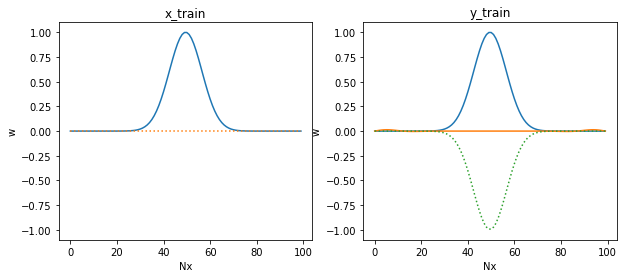

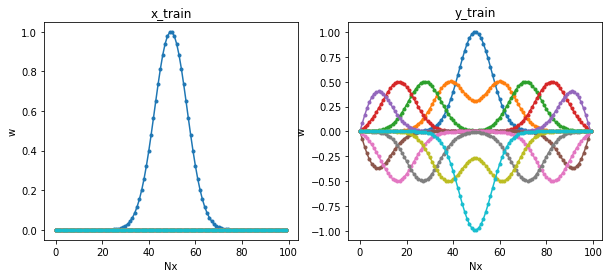

In [8]:
import tensorflow as tf

epoch_max    = int(100e3)
Encoder_size = 20;
RNN_size     = 15;
depth = 0
reg   = 0#1e-6#1e-4
hyperparams = [RNN_size, depth, reg]
#neurons , depth , reg = int(hyperparams[0]), int(hyperparams[1]), hyperparams[2]
act_RNN , act_Dense = 'tanh', 'linear'#'tanh', 'linear'

x_train = np.zeros((1, Nt, Ny))
y_train = np.zeros((1, Nt, Ny))
x_train[0,0,:]=M_w_ALE[:,0]
for tcount in range(Nt):
    y_train[0,tcount,:] = M_w_ALE[:,tcount]
#%%
fig = plt.figure(figsize=(10, 4))

ax1 = plt.subplot(121)
plt.plot(x_train[0,0,:] )
plt.plot(x_train[0,-1,:], linestyle='dotted' )
plt.xlabel('Nx')
plt.ylabel('w')
plt.title('x_train')
plt.ylim(ymin, ymax )

ax1 = plt.subplot(122)
plt.plot(y_train[0,0,:] )
plt.plot(y_train[0,int(Nt/2),:] )
plt.plot(y_train[0,-1,:], linestyle='dotted' )

plt.xlabel('Nx')
plt.ylabel('w')
plt.title('y_train')
plt.ylim(ymin, ymax )

plt.show()
#%%
fig = plt.figure(figsize=(10, 4))

ax1 = plt.subplot(121)
#plt.plot(x_train[0,0,:] )
#plt.plot(x_train[0,-1,:], linestyle='dotted' )
plt.plot(np.transpose(x_train[0,np.linspace(1,Nt,10).astype(int)-1,:]),'.-')
plt.xlabel('Nx')
plt.ylabel('w')
plt.title('x_train')
#plt.ylim(ymin, ymax )

ax1 = plt.subplot(122)
#plt.plot(y_train[0,0,:] )
#plt.plot(y_train[0,int(Nt/2),:] )
#plt.plot(y_train[0,-1,:], linestyle='dotted' )
plt.plot(np.transpose(y_train[0,np.linspace(1,Nt,10).astype(int)-1,:]),'.-')

plt.xlabel('Nx')
plt.ylabel('w')
plt.title('y_train')
#plt.ylim(ymin, ymax )

plt.show()

In [9]:
# Fully Connected : activation(W * a + bias); W \in R{Nx}{Encoder_size}, bias \in R{Encoder_size}
encoder =  tf.keras.layers.Dense( Encoder_size , 
                                 input_shape = (None, Nx),
                                 activation='linear', 
                                 use_bias=True, 
                                 name='encoder')

# RNN Layer : 
RNNLayer = tf.keras.layers.LSTM(  RNN_size  ,  
                                activation = act_RNN,
                                return_sequences = True,
#                               input_shape = (None, Nx),
                                kernel_regularizer=tf.keras.regularizers.l2(reg),
                                activity_regularizer=tf.keras.regularizers.l1(reg),
                                name='RNNLayer');
decoder =  tf.keras.layers.Dense( Encoder_size , 
                                 activation='linear', 
                                 use_bias=True, 
                                 name='decoder')
Denseout =  tf.keras.layers.Dense( Ny , activation='linear', use_bias=True, name='Dense')

model = tf.keras.models.Sequential();
model.add( encoder )
model.add( RNNLayer )
for lcount in range(depth):
    model.add( tf.keras.layers.LSTM(  RNN_size  ,  
                                    activation = act_Dense,
                                    return_sequences = True,
                                    kernel_regularizer=tf.keras.regularizers.l2(reg),
                                    activity_regularizer=tf.keras.regularizers.l1(reg),
                                    name="RNNLayerD" + str(lcount + 1) ))

model.add( decoder )
model.add( Denseout )
#%%
import os
current_dir =  os.getcwd()
tb = tf.keras.callbacks.TensorBoard(log_dir=current_dir, 
                                    histogram_freq=0,
                                    write_graph=True, write_grads=False, write_images=False, 
                                    embeddings_freq=0, embeddings_layer_names=None, 
                                    embeddings_metadata=None, embeddings_data=None, 
                                    update_freq=100)

checkpoint_path = "training_burgers_ALE/Buergers_ALE-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(
                                                filepath=checkpoint_path, 
                                                verbose=1, 
                                                save_weights_only=True,
                                                save_freq=5000)

reduce_lr = None#tf.keras.callbacks.ReduceLROnPlateau(monitor='lr', factor=0.2,
               #               patience=10, min_lr=0.0001)
#my_adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=Fa);
model.compile(optimizer= 'adam', # 'adam', 'RMSprop'
              loss     = 'mean_absolute_error', #loss='mean_absolute_percentage_error',mean_absolute_error
              metrics = ['mean_absolute_error'] )
model.summary()

shuffle_value = True

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Dense)              (None, None, 20)          2020      
_________________________________________________________________
RNNLayer (LSTM)              (None, None, 15)          2160      
_________________________________________________________________
decoder (Dense)              (None, None, 20)          320       
_________________________________________________________________
Dense (Dense)                (None, None, 100)         2100      
Total params: 6,600
Trainable params: 6,600
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir '/content'

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 8380.

In [11]:
# Loads the weights
# model.load_weights( "training_wave_25x25_2/cp-25x25-67134.ckpt")
t = time.time()
train_history = model.fit(x_train, 
                    y_train, 
                    epochs      = epoch_max, 
                    verbose     = 0, 
                    shuffle     = shuffle_value, 
                    callbacks   = [tb,cp_callback])
t = time.time() - t
print(t)  


Epoch 05000: saving model to training_burgers_ALE/Buergers_ALE-5000.ckpt

Epoch 10000: saving model to training_burgers_ALE/Buergers_ALE-10000.ckpt

Epoch 15000: saving model to training_burgers_ALE/Buergers_ALE-15000.ckpt

Epoch 20000: saving model to training_burgers_ALE/Buergers_ALE-20000.ckpt

Epoch 25000: saving model to training_burgers_ALE/Buergers_ALE-25000.ckpt

Epoch 30000: saving model to training_burgers_ALE/Buergers_ALE-30000.ckpt

Epoch 35000: saving model to training_burgers_ALE/Buergers_ALE-35000.ckpt

Epoch 40000: saving model to training_burgers_ALE/Buergers_ALE-40000.ckpt

Epoch 45000: saving model to training_burgers_ALE/Buergers_ALE-45000.ckpt

Epoch 50000: saving model to training_burgers_ALE/Buergers_ALE-50000.ckpt

Epoch 55000: saving model to training_burgers_ALE/Buergers_ALE-55000.ckpt

Epoch 60000: saving model to training_burgers_ALE/Buergers_ALE-60000.ckpt

Epoch 65000: saving model to training_burgers_ALE/Buergers_ALE-65000.ckpt

Epoch 70000: saving model

In [12]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)
 
file_name  = equation+'_Eulerian_Ensize'+str(Encoder_size)+'_RNNsize'+str(RNN_size)+'.h5'
model.save(file_name)  # creates a HDF5 file 'my_model.h5'

if ~os.system('cp '+'/content/'+file_name+' '+'drive/My*/ALE_Python/'): print('Model copied')

Model copied


In [13]:
file_name_hist = equation+'_Eulerian_Ensize'+str(Encoder_size)+'_RNNsize'+str(RNN_size)+'_history.pkl'
f = open(file_name_hist,"wb")
pickle.dump(train_history.history,f)
f.close()

if ~os.system('cp '+'/content/'+file_name_hist+' '+'drive/My*/ALE_Python/'): print('History saved and copied')

History saved and copied


In [1]:
#%% Plot training & validation accuracy values
fig = plt.figure(figsize=(15, 5))
ax0 = plt.subplot()
plt.semilogy(train_history.history['mean_absolute_error'])
plt.title('Model accuracy')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
#plt.ylim(1e-5, 1e-1)
plt.ylim(1e-5, 1e2)
plt.show()

print('===============================')
t = time.time()
model.evaluate(x_train, y_train, verbose=2);
t = time.time() - t
print(t)
print('===============================')

NameError: ignored

In [2]:
Npred    = Nt;
x_pred   = np.zeros((1, Npred, Ny))
x_pred[0,0,:]   = x_train[0,0,:]
y_pred_M = model.predict( x_pred )

#decode_speed = 0
y_pred_dec_M = y_pred_M.copy()
y_train_M = y_train.copy()

bc = x_pred[0,0,0]
#y_pred_dec_M = snapshot_decode(xmax, Npred/Nt*tmax, x_mid_0, Nx, Npred, decode_speed, batch_repeat, y_pred_dec_M, bc)
#y_train_M = snapshot_decode(xmax, tmax, x_mid_0, Nx, Nt, decode_speed, batch_repeat, y_train_M, bc)
##%%

y_pred_dec_M = interp1d_loop(M_x_ALE, y_pred_dec_M[0,:,:].T, M_x_0, Nx, Nt, bc);

NameError: ignored

(-0.11000000000000001, 0.11000000000000001)

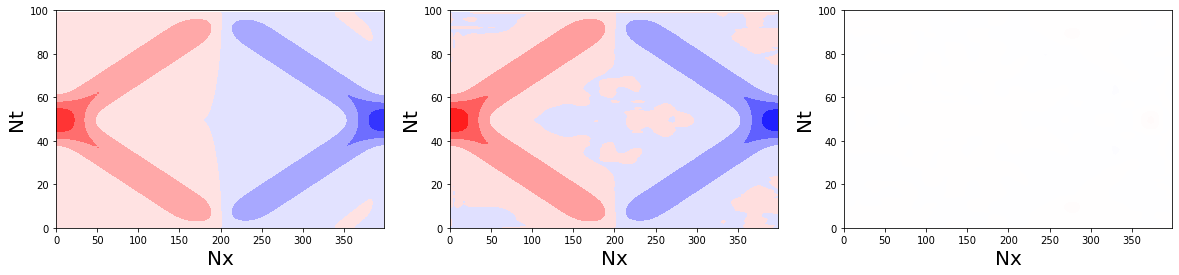

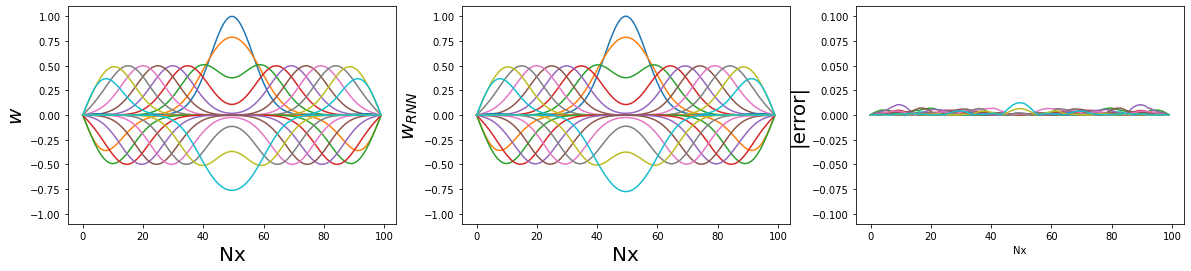

In [16]:
fig = plt.figure(figsize=(20, 4));
plt.set_cmap('bwr') # a good start: blue to white to red colormap

ax1 = plt.subplot(131)
plt.contourf(X_E_FOM,  vmin=ymin, vmax=ymax)
plt.ylim(0, Nx)
plt.xlabel('Nx',  fontsize=20)
plt.ylabel('Nt',  fontsize=20)

ax1 = plt.subplot(132)
plt.contourf(y_pred_dec_M)#,  vmin=ymin, vmax=ymax)
plt.ylim(0, Nx)
plt.xlabel('Nx',  fontsize=20)
plt.ylabel('Nt',  fontsize=20)

ax1 = plt.subplot(133)
plt.contourf(X_E_FOM-y_pred_dec_M,  vmin=ymin, vmax=ymax)
plt.ylim(0, Nx)
plt.xlabel('Nx',  fontsize=20)
plt.ylabel('Nt',  fontsize=20)
#%%
dNt = 20
Npred = Nt
indices = ()
fig = plt.figure(figsize=(20, 4));
ax1 = plt.subplot(131)
plt.plot(np.transpose(X_E_FOM[:,0:Npred:dNt].T));
plt.xlabel('Nx',  fontsize=20)
plt.ylabel(r'$w$', fontsize=20)
plt.ylim(ymin, ymax )

ax1 = plt.subplot(132)
plt.plot(np.transpose(y_pred_dec_M[:,0:Npred:dNt].T));

plt.xlabel('Nx',  fontsize=20)
plt.ylabel(r'$w_{RNN}$', fontsize=20)
plt.ylim(ymin, ymax )


ax1 = plt.subplot(133)
plt.plot(np.abs(np.transpose(X_E_FOM[:,0:Npred:dNt].T-y_pred_dec_M[:,0:Npred:dNt].T )) );

plt.xlabel('Nx')
plt.ylabel('|error|', fontsize=20)
plt.ylim(-0.1*ymax, 0.1*ymax )